In [48]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<h1>Model Evaluation and Selection</h1>

<p>In this assignment we will introduce some techniques to evaluate the quality of a method and how to select good parameter values.</p>

<p>We will be using the scikit built-in breast_cancer data set. It is binary classification problem where breast masses are classified as malignin (equal 0) or benign (equal 1).</p>

In [49]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()

data = dataset.data
target = dataset.target

###Find how many features we have and their names
features = dataset.feature_names
print "there are ",dataset.feature_names.size, 'features in the datasets namely: ' 
print dataset.feature_names

#The columns 10 to 19 are measurements errors and we can drop them without affecting much the work done here
###Remove the columns 10 to 19 in the data

# index = [9,10,11,12,13,14,15,16,17,18]
data_sub = np.delete(data, np.s_[10:20], axis=1)



there are  30 features in the datasets namely: 
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [50]:
data_sub.shape

(569, 20)

In [51]:
from sklearn.preprocessing import scale
data_scaled = scale(data_sub)

<h2>Example on a Single Decision Tree</h2>

<p>In this section we will introduce evaluation and paramtere selection techniques on a single decision tree.</p>

<h4>Simple Evaluation</h4>
<p>Evaluating the accuracy of a method can naively be done by splitting the data set in a training set and a test set.
We train our classifier on the training set (obviously) and we evaluate the accuracy on the test set.<br>
In scikit this is easily done by using the <i>.score()</i> functions of the classifier.</p>


In [52]:
from sklearn.cross_validation import train_test_split

###Split the data in train and test sets and the target in train_target and test_target (ratio 70%-30%)
## Hint : by using the keyword "random_state=0" when you call train_test_split
##        you make sure that the splits are the same for both data and target

train, test, train_target, test_target = train_test_split(data_scaled, target, test_size=0.3, random_state=0)

###Import a decision tree and train it on the training set with the default settings
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(train, train_target)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [53]:
###Compute the accuracy on the test set
pred_test = dtc.predict(test)
dtc.score(test, test_target)

0.94152046783625731

<p>The accuracy is simply giving you the amount of samples that have been correctly classified<br>
Other methods to measure the quality of the classifier are available. For instance one can use the F1 score. F1 score use the <i>precision</i> and <i>recall</i> (see https://en.wikipedia.org/wiki/Precision_and_recall) to evaluate the quality of a classification.</p>

In [54]:
from sklearn.metrics import f1_score
f1_score(test_target,pred_test,average='binary')


0.95238095238095233

<p>It is also possible to have the detail of precision and recall for both classes :</p>

In [55]:
from sklearn.metrics import classification_report
print classification_report(test_target, pred_test, target_names=['malignant', 'benign'])


             precision    recall  f1-score   support

  malignant       0.88      0.97      0.92        63
     benign       0.98      0.93      0.95       108

avg / total       0.94      0.94      0.94       171



<p>We started this study by doing a random separation for the train/test sets. Actually all scores of tests performed so far depend on this separation.</p>

<h4> <u>QUESTION 1 :</u> Explain why all scores are specific to our first sets split.</h4>
<p><i>The function, <em style="color:red">train_test_split</em>, splits data into subsets randomly (using pseudo-random number generator).</i></p>

<h4>Cross Validation</h4>

<p>Another way to evaluate the accuracy of a decision tree (and any method in general) is to use a cross validation technique :
Basically it consists in first dividing the data set in <i>k</i> sets named <i>folds</i>, then train the classifier on <i>k-1</i> folds and evaluate the accuracy on the remaining fold.</p>
<p>In scikit this can be done by using the <i>cross_val_score</i> function</p>

In [56]:
from sklearn.cross_validation import cross_val_score

###use the cross_val_score function on the whole dataset
cvs = cross_val_score(dtc, data_scaled, target)

#When calling the cross_val_score it returns one score per fold
#As by default the function uses a three-fold separation you have three value
###Compute and print the mean and the standard deviation of the cross_val_score function

print("Accuracy: %0.2f (+/- %0.2f)" % (cvs.mean(), cvs.std() * 2))

Accuracy: 0.91 (+/- 0.06)


<p>Several techniques exist to divide the data set in folds (see http://scikit-learn.org/stable/modules/cross_validation.html for more details).</p>
<p>Nonetheless, it is worth mentioning another technique : the ShuffleSplit. This technique generates a pre-defined number of independent train/test dataset splits. Samples are first shuffled and then split into a pair of train and test sets.</p>
<p>This can be implemented as follow :</p>

In [57]:
from sklearn.cross_validation import ShuffleSplit
cv_ss = ShuffleSplit(data_scaled.shape[0],n_iter=5,test_size=0.4,random_state=0)

###Use again the cross_val_score function and set "cv=cv_ss"
cvs1 = cross_val_score(dtc, data_scaled, target, cv=cv_ss)
###Compute again the mean and the standard deviation of the output
print("Accuracy: %0.2f (+/- %0.2f)" % (cvs1.mean(), cvs1.std() * 2))


Accuracy: 0.92 (+/- 0.02)


<h4> <u>QUESTION 2 :</u> Are results very different?</h4>
<p><i>No.</i></p>

<h3>Finding Optimal Parameters</h3>

<p>In the previous section we have use the default settings for our classifiers but this is usually not necessarily the most optimal choice.</p>
<p>In this section we will introduce tools to find good parameters value.</p>

<h4>Grid Search - a brute force approach</h4>
<p>A decision tree has several parameters we can change to optimize the classification. Scikit offers the possibility to investigate several parameters using <i>GridSearchCV</i>. You simply need to define a "parameter grid" (a dictionary in python) that defines the parameters values you want to try and feed it to a GridSearchCV object :</p>

In [58]:
from sklearn.grid_search import GridSearchCV

###Example of a parameter grid dictionary, run it once and then include more parametes in p_grid
p_grid=dict({'criterion':['entropy','gini'], 'max_depth':[None,3,4,5,6,8,9,10],'presort':[bool, False],
             'random_state':[10, None],'max_leaf_nodes':[None,7,8,25,15,10], 'max_features':['auto','sqrt','log2']})

#grd = GridSearchCV(<classifier>,cv=3,param_grid=<dictionary of parameters to investigate>)
#grd.fit(<training set>,<train set targets>)
grd = GridSearchCV(dtc,cv=3,param_grid=p_grid)
grd.fit(train,train_target)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'presort': [<type 'bool'>, False], 'random_state': [10, None], 'criterion': ['entropy', 'gini'], 'max_features': ['auto', 'sqrt', 'log2'], 'max_leaf_nodes': [None, 7, 8, 25, 15, 10], 'max_depth': [None, 3, 4, 5, 6, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

<h4> <u>QUESTION 2 :</u> What does the "CV" at the end of GridSearchCV stands for? What is it telling you?</h4>
    <p><i>Cross Validation. The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.</i></p>

In [59]:
#You can ask for the best parameters found by running the following command
grd.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': 10,
 'presort': bool,
 'random_state': None}

In [60]:
#And creat directly a new classifier with the optimal parameters by running
new_dtc = grd.best_estimator_

###Check the "new_dtr" parameters
new_dtc.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': bool,
 'random_state': None,
 'splitter': 'best'}

In [61]:
###Now train the new classifier
new_dtc.fit(train, train_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=10, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=<type 'bool'>, random_state=None, splitter='best')

In [62]:
###Compute its accuracy
new_pred_test = new_dtc.predict(test)
f1_score(test_target,new_pred_test,average='binary')

0.96296296296296291

In [63]:
###print the classification report
print classification_report(test_target, new_pred_test, target_names=['malignant', 'benign'])

             precision    recall  f1-score   support

  malignant       0.94      0.94      0.94        63
     benign       0.96      0.96      0.96       108

avg / total       0.95      0.95      0.95       171



<h4>Learning and Validation Curves</h4>
<p> Scikit provides additional tools to tune our algorithm.<br>
One useful tool is the learning curve. It gives the cross-validated training and test scores for different training sets sizes.
We can use it on the previously defined new classifier "new_dtr" :</p>

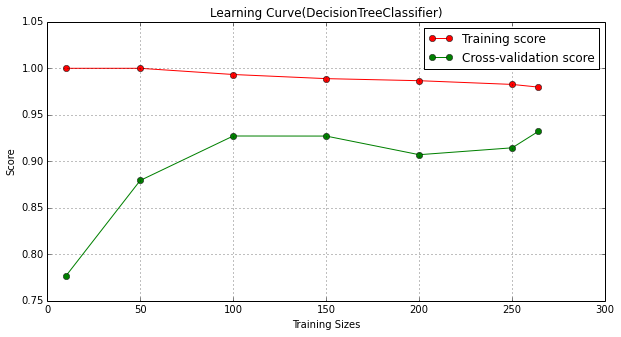

In [64]:
from sklearn.learning_curve import learning_curve

###Compute the learning curve
train_sizes,train_scores,test_scores = learning_curve(new_dtc,train, train_target,
                                                   train_sizes=[10, 50, 100, 150, 200, 250, 264],cv=3, n_jobs=1)
#The list of training sizes can be absolute numbers or amount if between (0,1]

###Visualize the learning curve (don't forget labels, title,legend,etc)
plt.figure(figsize=(10,5))
plt.title('Learning Curve(DecisionTreeClassifier)')
plt.xlabel("Training Sizes")
plt.ylabel("Score")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")
#You should see why I chose a 70%-30% ratio

<h4> <u>QUESTION 3 :</u> Why isn't the training score equal to one?</h4>
<p><i>Because of Cross Validation(Randomness)</i></p>

<p>A second tool meant to investigate a specific parameter influence on scores is the <i>validation curve</i>. It is basically like a gridsearch with a single parameter. </p>

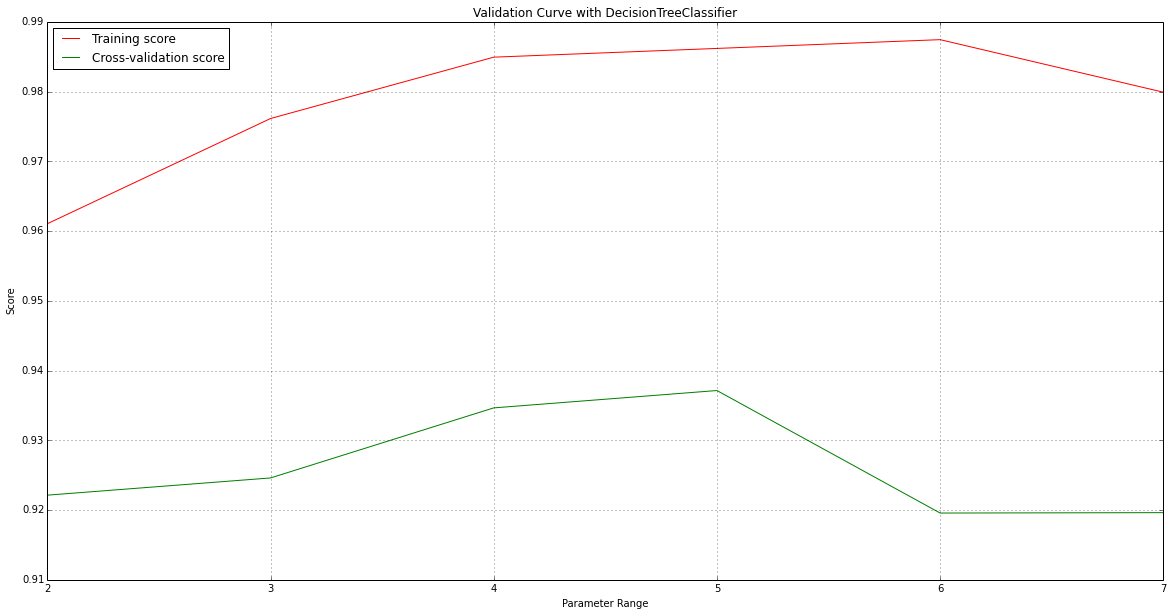

In [65]:
from sklearn.learning_curve import validation_curve

#Just an example
train_scores,test_scores = validation_curve(new_dtc,train,train_target,param_name='max_depth',
                                          param_range=np.arange(2,8),cv=3)

###Plot the validation curve
plt.figure(figsize=(20,10))
plt.title('Validation Curve with DecisionTreeClassifier')
plt.xlabel("Parameter Range")
plt.ylabel("Score")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()
plt.plot(np.arange(2,8), train_scores_mean, label="Training score", color="r")
plt.plot(np.arange(2,8), test_scores_mean, label="Cross-validation score",
             color="g")
plt.legend(loc="best")


<h3>Application - Evaluating the Random Forest classifier and the SVC</h3>

<p>In the following you will apply the evaluation and optimization tools to compare the Random Forest technique and the SVC technique.</p>

In [66]:
###Import the "RandomForestClassifier" classifier
from sklearn.ensemble import RandomForestClassifier
###Train it on the training set
rfc = RandomForestClassifier()
rfc.fit(train, train_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [67]:
###Import the "SVC" classifier
from sklearn.svm import SVC
###Train it on the training set  (don't forget to scale it!)
svc = SVC()
svc.fit(scale(train), train_target)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

<p>Before evaluating the performance of both classifiers we will first determine the best values for their parameters</p>

In [68]:
###Using the grid search optimize the Random Forest Classifier
rfc_grid=dict({'criterion':['entropy','gini'], 'max_depth':[None,5,9],
             'max_leaf_nodes':[None,7], 'max_features':[None, 15],'min_samples_split':[2,5],
             'min_samples_leaf':[1, 2, 6]})
rfc_grd = GridSearchCV(rfc,cv=3,param_grid=rfc_grid)
rfc_grd.fit(train,train_target)


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [None, 15], 'criterion': ['entropy', 'gini'], 'min_samples_split': [2, 5], 'max_leaf_nodes': [None, 7], 'max_depth': [None, 5, 9], 'min_samples_leaf': [1, 2, 6]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [69]:
rfc_grd.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 15,
 'max_leaf_nodes': None,
 'min_samples_leaf': 6,
 'min_samples_split': 2}

In [22]:
###Create a new Random Forest Classifier using the best parameters found
new_rfc = rfc_grd.best_estimator_

In [23]:
###Using the grid search optimize the SVC Classifier
#(!don't forget to scale the data!)

svc_grid=dict({'C':[1.0,10.0, 100.0],'degree':[3,1,5],'kernel':['rbf', 'linear', 'poly','sigmoid'],
               'tol':[0.01, 0.03, 0.05]})
svc_grd = GridSearchCV(svc,cv=3,param_grid=svc_grid)
svc_grd.fit(scale(train),train_target)


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'C': [1.0, 10.0, 100.0], 'degree': [3, 1, 5], 'tol': [0.01, 0.03, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [24]:
svc_grd.best_params_

{'C': 1.0, 'degree': 1, 'kernel': 'poly', 'tol': 0.01}

In [25]:
###Create a new SVC using the best parameters found
new_svc = svc_grd.best_estimator_

<p>Now we have optimized out two classifier we can compare how they perform</p>

In [26]:
###Compute the accuracy of both classifiers on the training set using the cross_val_score
# (!scale for SVC!)
#RandomForestClassifier
cv_ss = ShuffleSplit(train.shape[0],n_iter=5,test_size=0.4,random_state=0)
cvs2 = cross_val_score(new_rfc, train, train_target, cv=cv_ss)

#SVC
cv_ss = ShuffleSplit(scale(train).shape[0],n_iter=5,test_size=0.4,random_state=0)
cvs3 = cross_val_score(new_svc, scale(train), train_target, cv=cv_ss)


#Print the results (average and std)

print("Accuracy of RandomForestClassifier: %0.2f (+/- %0.2f)" % (cvs2.mean(), cvs2.std() * 2))
print("Accuracy of SVC: %0.2f (+/- %0.2f)" % (cvs3.mean(), cvs3.std() * 2))


Accuracy of RandomForestClassifier: 0.95 (+/- 0.03)
Accuracy of SVC: 0.98 (+/- 0.01)


<h4> <u>QUESTION 4 :</u> Which classifier gives the best accuracy?</h4>
<p><i>SVC</i></p>

In [27]:
###Print the Classification report for the Random Forest Classifier
print classification_report(test_target, new_rfc.predict(test), target_names=['malignant', 'benign'])

             precision    recall  f1-score   support

  malignant       0.94      0.95      0.94        63
     benign       0.97      0.96      0.97       108

avg / total       0.96      0.96      0.96       171



In [28]:
###Do the same for the SVC classifier
print classification_report(test_target, new_svc.predict(test), target_names=['malignant', 'benign'])

             precision    recall  f1-score   support

  malignant       0.98      0.94      0.96        63
     benign       0.96      0.99      0.98       108

avg / total       0.97      0.97      0.97       171



<h4> <u>QUESTION 5 :</u> Analyze the last two classification reports.</h4>
<ul>
<li>The Random Forest Classifier has 94% ability not to label as malignant a benign breast cancer and 97% tendency not to label as benign a malignant breast cancer</li>
<li>It has 95% ability to find breast cancer cases that is malignant and 96% ability to find benign breast cancer</li>

<li>SVC has 98% ability not to label as malignant a benign breast cancer and 96% tendency not to label as benign a malignant breast cancer</li>
<li>It has 94% ability to find breast cancer cases that is malignant and 99% ability to find benign breast cancer</li>
</ul>

<h4> <u>QUESTION 6 :</u> Recall the classification report from the optimized decision tree to conclude on the best algorithm to chose to efficiently detect malignant masses.</h4>
<p><i>SVC is the most efficient. Although, Random Forest Classifier outperforms it in detecting malignant masses accurately but in terms of computational time, SVC is the most efficient among the 3 classifiers.</i></p>

<h4> <u>BONUS :</u> Repeat the optimization and evalution procedure with the k-nearest neighbors approach.</h4>
<p><i>Type your answer here</i></p>

In [29]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
knn_grid=dict({'algorithm':['ball_tree','kd_tree','brute'], 'p':[2,4,6],
             'n_neighbors':[7,15]})

knn_grd = GridSearchCV(knn,cv=3,param_grid=knn_grid)
knn_grd.fit(train,train_target)

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'p': [2, 4, 6], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'n_neighbors': [7, 15]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [30]:
new_knn = knn_grd.best_estimator_

In [31]:
cv_ss = ShuffleSplit(train.shape[0],n_iter=5,test_size=0.4,random_state=0)
cvs4 = cross_val_score(new_knn, train, train_target, cv=cv_ss)
print("Accuracy of KNN: %0.2f (+/- %0.2f)" % (cvs4.mean(), cvs4.std() * 2))

Accuracy of KNN: 0.97 (+/- 0.02)


In [32]:
print classification_report(test_target, new_knn.predict(test), target_names=['malignant', 'benign'])

             precision    recall  f1-score   support

  malignant       0.97      0.90      0.93        63
     benign       0.95      0.98      0.96       108

avg / total       0.95      0.95      0.95       171

